# Topic Trends - Full Corpus

This code was created from Martha and Sean's emerging topic code. 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm
from scipy import stats

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

### Data Ingestion

In [2]:
# pull in data
df = pd.read_pickle("../../../data/prd/Paper/FR_meta_and_final_tokens_23DEC21.pkl")
df.reset_index(inplace = True, drop = True)

In [3]:
df.shape

(1143869, 30)

In [4]:
df.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...


In [5]:
# input needed for NMF (from Scikit-Learn) is one string per document (not a list of strings)

text = df["final_tokens"]

### Functions needed for all models

In [6]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [7]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF

In [8]:
stop_wds = ['research', 'aim', 'project']

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)

In [9]:
# create model

num_topics = 10

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 277.5099747180939


In [10]:
print_topics(topic_term, tfidf_vectorizer, 10)


Topic 0:
('cell', 10.668557432205468)
('immune', 1.847836691658534)
('tumor', 1.688736616592652)
('stem', 1.6749800337513352)
('response', 1.527198947905007)
('mouse', 1.523614356176636)
('signal', 1.3733589017141299)
('tissue', 1.16804364007847)
('antigen', 1.0324385131861962)
('differentiation', 0.9874420044185972)

Topic 1:
('program', 3.8594002521054698)
('training', 3.4780137458047666)
('student', 2.50637335299414)
('trainee', 2.306834849612024)
('faculty', 1.735034529186246)
('career', 1.384368935298699)
('science', 1.2410511488772036)
('mentor', 1.1815641608468963)
('year', 1.0406537719201157)
('graduate', 1.0347604551969778)

Topic 2:
('patient', 3.5455510640491092)
('clinical', 2.814708540201703)
('trial', 1.7956875168608994)
('treatment', 1.7459735636488949)
('disease', 1.2541386413502236)
('drug', 1.1444980417747437)
('therapy', 1.1131352527004155)
('care', 1.052459735277517)
('phase', 0.7805126285334223)
('outcome', 0.7550380110973409)

Topic 3:
('cancer', 7.63795961546868

### Topic Trends

In [11]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["FY"] = df["FY"]

In [12]:
topic_frame

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,FY
0,0.000000,0.000566,0.000000,0.000000,0.001459,0.000000,0.013039,0.000000,0.000689,0.001791,2008
1,0.000000,0.007832,0.000000,0.000250,0.001524,0.000000,0.012234,0.000000,0.001679,0.000000,2008
2,0.000000,0.005528,0.000000,0.000000,0.000000,0.000000,0.003304,0.000000,0.017011,0.005042,2008
3,0.000000,0.006727,0.000000,0.000000,0.003900,0.000282,0.005225,0.000000,0.003085,0.000000,2008
4,0.000361,0.007785,0.000000,0.000230,0.002618,0.000000,0.017477,0.002314,0.001320,0.000000,2008
...,...,...,...,...,...,...,...,...,...,...,...
1143864,0.000477,0.006384,0.000000,0.000000,0.001829,0.000000,0.005626,0.004673,0.001397,0.007078,2020
1143865,0.002197,0.011174,0.000000,0.000106,0.000000,0.000000,0.010446,0.005629,0.006994,0.003808,2020
1143866,0.000913,0.000000,0.000726,0.000000,0.001569,0.001677,0.008986,0.000960,0.007792,0.002005,2020
1143867,0.000197,0.005415,0.000000,0.000000,0.000272,0.000101,0.013660,0.002393,0.003161,0.001075,2020


#### compute count of projects with weight > 0 for each topic

In [13]:
topic_proj_count = topic_frame.copy()

In [14]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,FY
0,0.000000,0.000566,0.0,0.00000,0.001459,0.000000,0.013039,0.000000,0.000689,0.001791,2008
1,0.000000,0.007832,0.0,0.00025,0.001524,0.000000,0.012234,0.000000,0.001679,0.000000,2008
2,0.000000,0.005528,0.0,0.00000,0.000000,0.000000,0.003304,0.000000,0.017011,0.005042,2008
3,0.000000,0.006727,0.0,0.00000,0.003900,0.000282,0.005225,0.000000,0.003085,0.000000,2008
4,0.000361,0.007785,0.0,0.00023,0.002618,0.000000,0.017477,0.002314,0.001320,0.000000,2008


In [15]:
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["FY"] = topic_proj_count["FY"]

In [16]:
topic_count_bool

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,FY
0,False,True,False,False,True,False,True,False,True,True,2008
1,False,True,False,True,True,False,True,False,True,False,2008
2,False,True,False,False,False,False,True,False,True,True,2008
3,False,True,False,False,True,True,True,False,True,False,2008
4,True,True,False,True,True,False,True,True,True,False,2008
...,...,...,...,...,...,...,...,...,...,...,...
1143864,True,True,False,False,True,False,True,True,True,True,2020
1143865,True,True,False,True,False,False,True,True,True,True,2020
1143866,True,False,True,False,True,True,True,True,True,True,2020
1143867,True,True,False,False,True,True,True,True,True,True,2020


In [17]:
topic_count_bool.sum(axis=1).median()

5.0

In [18]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("FY").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "FY")  # pretty sure this is unnecessary
topic_counts["FY"] = topic_counts["FY"].astype(int)

In [19]:
topic_counts

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,60139,39036,56583,36158,42571,30359,60404,66437,51575,57736
1,2009,65227,44870,61097,39363,45887,32669,66824,71662,58172,62071
2,2010,62786,43373,59682,38608,44336,32014,64028,68769,58361,59096
3,2011,55868,39391,54021,34655,39877,28561,56639,61157,52953,52779
4,2012,51550,37163,50320,31860,36628,26671,52123,55397,49993,48868
5,2013,51654,36812,50387,32543,38341,26994,53160,55278,47084,48995
6,2014,50589,35698,50567,32062,38258,26753,53242,54235,45384,48604
7,2015,51772,36281,51885,32572,38997,27649,55292,55040,46659,49182
8,2016,52254,37478,52974,33018,39669,28109,56227,55303,47584,49650
9,2017,51464,36248,53070,32664,38523,27964,54265,54421,46340,49257


In [20]:
# note if filtering data set to specific years - set here

year_st = 2008
year_end = 2020

In [21]:
topic_counts_filt = topic_counts[topic_counts["FY"] >= year_st] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["FY"] <= year_end]

In [22]:
topic_counts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,60139,39036,56583,36158,42571,30359,60404,66437,51575,57736
1,2009,65227,44870,61097,39363,45887,32669,66824,71662,58172,62071
2,2010,62786,43373,59682,38608,44336,32014,64028,68769,58361,59096
3,2011,55868,39391,54021,34655,39877,28561,56639,61157,52953,52779
4,2012,51550,37163,50320,31860,36628,26671,52123,55397,49993,48868
5,2013,51654,36812,50387,32543,38341,26994,53160,55278,47084,48995
6,2014,50589,35698,50567,32062,38258,26753,53242,54235,45384,48604
7,2015,51772,36281,51885,32572,38997,27649,55292,55040,46659,49182
8,2016,52254,37478,52974,33018,39669,28109,56227,55303,47584,49650
9,2017,51464,36248,53070,32664,38523,27964,54265,54421,46340,49257


In [23]:
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0    716437
Topic 1    500078
Topic 2    712712
Topic 3    447790
Topic 4    525814
Topic 5    378375
Topic 6    744903
Topic 7    769032
Topic 8    654543
Topic 9    682566
dtype: int64

#### calculate mean topic weight by year and standard errors on means

In [24]:
topic_frame_se = topic_frame.groupby("FY").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "FY")
topic_frame_se["FY"] = topic_frame_se["FY"].astype(int)

topic_wts_se_filt = topic_frame_se[topic_frame_se["FY"] >= year_st] 
topic_wts_se_filt = topic_wts_se_filt[topic_wts_se_filt["FY"] <= year_end]

In [25]:
topic_frame = topic_frame.groupby("FY").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "FY")
topic_frame["FY"] = topic_frame["FY"].astype(int)

In [26]:
topic_frame

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,0.002984,0.003336,0.003937,0.002292,0.002497,0.001439,0.003807,0.005381,0.003105,0.003245
1,2009,0.003039,0.003438,0.003981,0.002379,0.002451,0.001413,0.004152,0.005381,0.003243,0.003299
2,2010,0.003111,0.003487,0.004148,0.002498,0.002590,0.001502,0.004074,0.005414,0.003473,0.003334
3,2011,0.003130,0.003692,0.004246,0.002591,0.002833,0.001575,0.004000,0.005392,0.003576,0.003410
4,2012,0.003140,0.003766,0.004448,0.002675,0.002899,0.001584,0.004096,0.005184,0.003739,0.003447
5,2013,0.003070,0.003768,0.004410,0.002700,0.003179,0.001565,0.004119,0.004993,0.003520,0.003331
6,2014,0.002986,0.003746,0.004533,0.002624,0.003241,0.001570,0.004182,0.004830,0.003465,0.003371
7,2015,0.002915,0.003719,0.004559,0.002507,0.003249,0.001594,0.004348,0.004708,0.003430,0.003359
8,2016,0.002897,0.003782,0.004608,0.002451,0.003237,0.001613,0.004381,0.004629,0.003415,0.003398
9,2017,0.002929,0.003763,0.004779,0.002450,0.003221,0.001658,0.004183,0.004636,0.003394,0.003553


In [27]:
# filter topic_frame for years 

topic_wts_filt = topic_frame[topic_frame["FY"] >= year_st] 
topic_wts_filt = topic_wts_filt[topic_wts_filt["FY"] <= year_end] 

In [28]:
topic_wts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,0.002984,0.003336,0.003937,0.002292,0.002497,0.001439,0.003807,0.005381,0.003105,0.003245
1,2009,0.003039,0.003438,0.003981,0.002379,0.002451,0.001413,0.004152,0.005381,0.003243,0.003299
2,2010,0.003111,0.003487,0.004148,0.002498,0.002590,0.001502,0.004074,0.005414,0.003473,0.003334
3,2011,0.003130,0.003692,0.004246,0.002591,0.002833,0.001575,0.004000,0.005392,0.003576,0.003410
4,2012,0.003140,0.003766,0.004448,0.002675,0.002899,0.001584,0.004096,0.005184,0.003739,0.003447
5,2013,0.003070,0.003768,0.004410,0.002700,0.003179,0.001565,0.004119,0.004993,0.003520,0.003331
6,2014,0.002986,0.003746,0.004533,0.002624,0.003241,0.001570,0.004182,0.004830,0.003465,0.003371
7,2015,0.002915,0.003719,0.004559,0.002507,0.003249,0.001594,0.004348,0.004708,0.003430,0.003359
8,2016,0.002897,0.003782,0.004608,0.002451,0.003237,0.001613,0.004381,0.004629,0.003415,0.003398
9,2017,0.002929,0.003763,0.004779,0.002450,0.003221,0.001658,0.004183,0.004636,0.003394,0.003553


In [29]:
topic_wts_se_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,0.000017,0.000028,0.000021,0.000022,0.000023,0.000019,0.000017,0.000023,0.000019,0.000018
1,2009,0.000016,0.000027,0.000020,0.000022,0.000022,0.000018,0.000017,0.000022,0.000019,0.000018
2,2010,0.000017,0.000028,0.000021,0.000023,0.000023,0.000019,0.000018,0.000023,0.000020,0.000019
3,2011,0.000018,0.000031,0.000022,0.000025,0.000027,0.000021,0.000019,0.000024,0.000022,0.000020
4,2012,0.000019,0.000032,0.000024,0.000026,0.000029,0.000022,0.000020,0.000024,0.000023,0.000021
5,2013,0.000018,0.000032,0.000024,0.000026,0.000030,0.000021,0.000020,0.000024,0.000022,0.000020
6,2014,0.000018,0.000032,0.000024,0.000026,0.000031,0.000022,0.000020,0.000023,0.000022,0.000021
7,2015,0.000017,0.000032,0.000024,0.000025,0.000031,0.000022,0.000020,0.000023,0.000021,0.000021
8,2016,0.000017,0.000031,0.000023,0.000024,0.000030,0.000022,0.000020,0.000022,0.000021,0.000021
9,2017,0.000017,0.000032,0.000024,0.000024,0.000030,0.000022,0.000020,0.000022,0.000021,0.000021


In [30]:
# perform regressions, track slopes

topic_slopes = []
p_values = []

for i in range(1,num_topics+1):
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    #topic_slopes.append(linear_fit.coef_[0][0])
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt.iloc[:,i].values)
    topic_slopes.append(linear_fit.slope)
    p_values.append(linear_fit.pvalue)


In [31]:
topic_slopes[:5]

[-1.8556546867601598e-05,
 5.4078597066467805e-06,
 8.438249983181252e-05,
 -4.197045382239681e-06,
 5.745164786901979e-05]

In [32]:
p_values[:5]

[0.003237190908895093,
 0.6818035992766467,
 5.363357518635821e-10,
 0.670539911289423,
 0.0024725087616603854]

In [33]:
leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

In [34]:
leg[:5]

['cell, immune, tumor, stem, response',
 'program, training, student, trainee, faculty',
 'patient, clinical, trial, treatment, disease',
 'cancer, tumor, breast, prostate, metastasis',
 'core, administrative, center, investigator, support']

In [35]:
n_by_topic.values

array([716437, 500078, 712712, 447790, 525814, 378375, 744903, 769032,
       654543, 682566])

In [36]:
# package up data 

reg_topics = pd.DataFrame()
reg_topics["Label"] = ''
reg_topics["n"] = n_by_topic.values
reg_topics["Slopex100"] = [slope*100 for slope in topic_slopes]
reg_topics["p-value"] = p_values
reg_topics["Topic Words"] = leg 

# sort by topic words
reg_topics = reg_topics.sort_values(by=["Topic Words"])

# add labels
for i in range(len(reg_topics)):
    reg_topics["Label"].iloc[i] = "P%d" % (i+1)

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [37]:
reg_topics

,Label,n,Slopex100,p-value,Topic Words
9,P1,682566,0.002597,1.195829e-04,"brain, neuron, ad, cognitive, neural"
3,P2,447790,-0.000420,6.705399e-01,"cancer, tumor, breast, prostate, metastasis"
0,P3,716437,-0.001856,3.237191e-03,"cell, immune, tumor, stem, response"
4,P4,525814,0.005745,2.472509e-03,"core, administrative, center, investigator, su..."
8,P5,654543,0.001616,1.840072e-01,"health, intervention, child, risk, care"
5,P6,378375,0.001345,2.450041e-03,"hiv, infection, vaccine, virus, aids"
2,P7,712712,0.008438,5.363358e-10,"patient, clinical, trial, treatment, disease"
1,P8,500078,0.000541,6.818036e-01,"program, training, student, trainee, faculty"
7,P9,769032,-0.010239,1.064148e-08,"protein, gene, dna, genetic, expression"
6,P10,744903,0.001243,2.838522e-01,"student, system, develop, datum, method"


In [39]:
#reg_topics.to_csv("./csvs/full_10topics.csv", index=False)

## Grid Plot

In [38]:
# sort topics by slope

def sort_list(x):
    return sorted(enumerate(x), key=lambda l: l[1], reverse=True)

In [39]:
sort_slopes = sort_list(topic_slopes)

sort_slopes[:5] # sort_slopes now goes from 0 to 29

[(2, 8.438249983181252e-05),
 (4, 5.745164786901979e-05),
 (9, 2.5966518198501194e-05),
 (8, 1.6156997025113226e-05),
 (5, 1.34483287850561e-05)]

In [40]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 0-29

# leg: indices 0-29

[2, 4, 9, 8, 5, 6, 1, 3, 0, 7]

In [41]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx] + ' \n' + title[idx:])
    

In [42]:
new_leg

['cell, immune, tumor, \n stem, response',
 'program, training, student, \n trainee, faculty',
 'patient, clinical, trial, \n treatment, disease',
 'cancer, tumor, breast, \n prostate, metastasis',
 'core, administrative, center, \n investigator, support',
 'hiv, infection, vaccine, \n virus, aids',
 'student, system, develop, \n datum, method',
 'protein, gene, dna, \n genetic, expression',
 'health, intervention, child, \n risk, care',
 'brain, neuron, ad, \n cognitive, neural']

In [43]:
# add topic labels

order_df = pd.DataFrame(leg, columns = ['Topic Words'])

In [44]:
order_df

,Topic Words
0,"cell, immune, tumor, stem, response"
1,"program, training, student, trainee, faculty"
2,"patient, clinical, trial, treatment, disease"
3,"cancer, tumor, breast, prostate, metastasis"
4,"core, administrative, center, investigator, su..."
5,"hiv, infection, vaccine, virus, aids"
6,"student, system, develop, datum, method"
7,"protein, gene, dna, genetic, expression"
8,"health, intervention, child, risk, care"
9,"brain, neuron, ad, cognitive, neural"


In [45]:
L_df = order_df.merge(reg_topics[['Label','Topic Words']], how='left', on='Topic Words') 

In [46]:
L_df

,Topic Words,Label
0,"cell, immune, tumor, stem, response",P3
1,"program, training, student, trainee, faculty",P8
2,"patient, clinical, trial, treatment, disease",P7
3,"cancer, tumor, breast, prostate, metastasis",P2
4,"core, administrative, center, investigator, su...",P4
5,"hiv, infection, vaccine, virus, aids",P6
6,"student, system, develop, datum, method",P10
7,"protein, gene, dna, genetic, expression",P9
8,"health, intervention, child, risk, care",P5
9,"brain, neuron, ad, cognitive, neural",P1


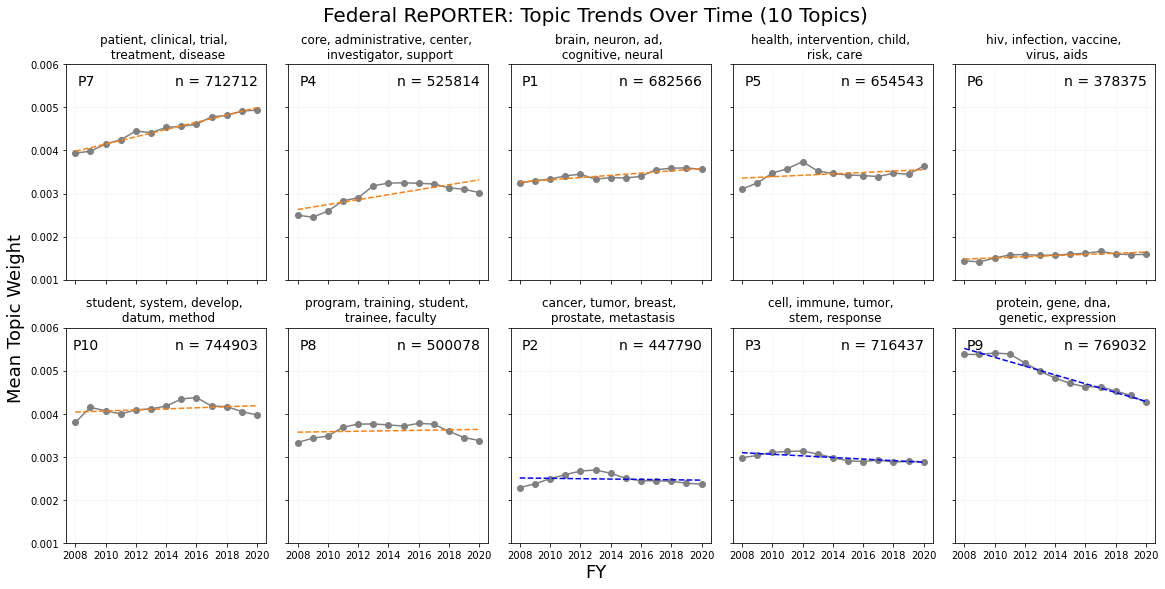

In [61]:
# set up grid
fig, ax = plt.subplots(2, 5, sharex = True, sharey = True, figsize=(16,8))
plt.ylim(bottom = 0.001, top = 0.006) 
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_filt.columns[col_idx+1]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt[col].values)
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.slope > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    if(count in []): # upward trend in 2020
        line_color = 'black'
    else: # downward trend in 2020
        line_color = 'gray'
    
    ax[i,j].errorbar(topic_wts_filt["FY"], topic_wts_filt[col], 
            yerr = np.array(topic_wts_se_filt[col]), fmt = '-o', color = line_color, zorder = 10) 
    
    ax[i,j].plot(topic_wts_filt["FY"], \
        (topic_wts_filt["FY"]*linear_fit.slope)+linear_fit.intercept, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    #if count == 16:
    #    ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
    #                      fontsize = 12)
    #elif count == 27:
    #    ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    #else:
    ax[i,j].set_title(new_leg[col_idx], fontsize = 12)
    
    # add topic number to each plot
    ax[i,j].text(0.10, 0.92, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.75, 0.92, "n = " + str(n_by_topic[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Federal RePORTER: Topic Trends Over Time (10 Topics)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.savefig("./figures/full_10topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.savefig("./figures/full_10topic_trends.pdf", dpi = 800, bbox_inches = "tight")
plt.show()

### Descriptive statistics on corpus

In [49]:
df["FY"].value_counts().sort_index()

2008     479
2009     549
2010     545
2011     532
2012     442
2013     412
2014     388
2015     433
2016     440
2017     450
2018     452
2019     457
2020    1992
Name: FY, dtype: int64

In [50]:
df["DEPARTMENT"].value_counts()

HHS     6473
NSF      869
USDA     189
DOD       24
VA        11
NASA       3
EPA        2
Name: DEPARTMENT, dtype: int64

In [51]:
# filter data frame by year and repeat descriptive statistics.  Limit years to those for emerging topic analysis.

filt_df = df.copy()
filt_df["FY"] = filt_df["FY"].astype('int')

filt_df = filt_df[filt_df["FY"] >= year_st]
filt_df = filt_df[filt_df["FY"] <= year_end]

In [52]:
year_counts = filt_df["FY"].value_counts().sort_index()
print(year_counts)

2008     479
2009     549
2010     545
2011     532
2012     442
2013     412
2014     388
2015     433
2016     440
2017     450
2018     452
2019     457
2020    1992
Name: FY, dtype: int64


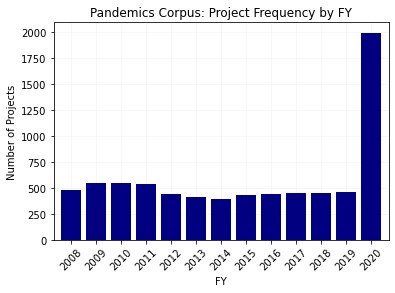

In [58]:
# plot
year = year_counts.index.tolist()
count = year_counts.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
plt.xticks(year, rotation=45)
plt.xlim(2007.3,2020.7)
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt.xlabel("FY")
plt.ylabel("Number of Projects")
plt.title("Pandemics Corpus: Project Frequency by FY");

plt.savefig("./figures/pan_startyr_freq.png", dpi = 800, bbox_inches = "tight")
plt.savefig("./figures/pan_startyr_freq.pdf", dpi = 800, bbox_inches = "tight")

In [59]:
agency_counts = filt_df["DEPARTMENT"].value_counts()
print(agency_counts)

HHS     6473
NSF      869
USDA     189
DOD       24
VA        11
NASA       3
EPA        2
Name: DEPARTMENT, dtype: int64


In [61]:
len(filt_df)

7571

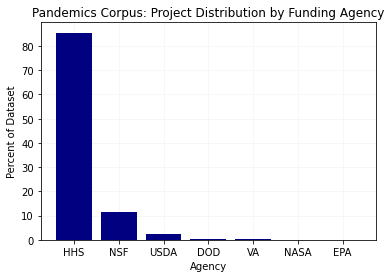

In [64]:
# plot
agency = agency_counts.index.tolist()
pct = 100*agency_counts.values/len(filt_df)

#reload(plt)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(agency, pct, color='navy')
plt.xlabel("Agency")
plt.ylabel("Percent of Dataset")
plt.title("Pandemics Corpus: Project Distribution by Funding Agency");

#plt.savefig("./figures/pan_agency_dist.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/pan_agency_dist.pdf", dpi = 800, bbox_inches = "tight")

In [65]:
filt_df.pivot_table(index=['DEPARTMENT','FY'], aggfunc='size')

DEPARTMENT  FY  
DOD         2009       1
            2013       2
            2014       2
            2016       3
            2017      11
            2018       5
EPA         2012       1
            2015       1
HHS         2008     447
            2009     505
            2010     512
            2011     502
            2012     412
            2013     390
            2014     368
            2015     394
            2016     414
            2017     417
            2018     430
            2019     439
            2020    1243
NASA        2009       1
            2012       1
            2015       1
NSF         2008      15
            2009      17
            2010      14
            2011      10
            2012       9
            2013       6
            2014       5
            2015      19
            2016      11
            2017       8
            2018       3
            2019       5
            2020     747
USDA        2008      17
            2009      24
        

In [66]:
filt_df.shape

(7571, 30)